In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display_html
from itertools import chain,cycle

# Homework 4

In this week's assigment we try to solve the following points:

- Generate a random a SxS matrix with C non zero entries and 1-C zeros (C is between zero and one). Set the diagonal to -d. The non-zero elements are drawn from a given distribution. Calculate the eigenvalues. Repeat different realizations and plot all the eigenvalues in the complex plane [Real part (x-axis) and imaginary part (y-axis)]. Compare this result with the expectations from the circular law.

- Generate the same as above but for mutualistic structure and find how the maximum real eigenvalues scales with S (use S=20,30,40,..100) and compare your numerical finding with the analytical expectations.

- Analyze the food web using the metrics we have seen in class. The file represent the weighted adjacency matrix of the food web. For the analysis you can binarize (zero and one) the matrix. You find the file in the google drive.

- Optional: calculate the same as 1) but with for the cascade model or for the nested mutualistic network. 

## 1) Random matrix

In [6]:
def random_matrix(S, C, d, distribution, parameters):

    # Generate a random a SxS matrix with non zero entries hsving a probability of C 
    # Set the diagonal to -d. 

    # S: number of species
    # C: percentage of non zero entries
    # d: diagonal value
    # distribution: numpy random distribution of the non zero entries
    # parameters: parameters of the numpy distribution (has to be a dictionary)

    # Generate a random matrix
    matrix = distribution(size=(S, S), **parameters)
    
    
    
    # Set the diagonal to -d
    np.fill_diagonal(matrix, -d)

    # Set the off-diagonal non zero entries to zero with a probability of 1-C
    matrix[np.triu(np.random.uniform(size = (S, S)), k = 1) > C]=0
    matrix[np.tril(np.random.uniform(size = (S, S)), k = -1) > C]=0

    


    # Calculate the eigenvalues
    eigenvalues = np.linalg.eigvals(matrix)
    
    

    return eigenvalues

In [7]:
realizations_number = 1000
S = 100
C = 0.7
d = 5
distribution = np.random.normal
std = 0.5
parameters={'loc': 0, 'scale': std}


print(f'''
The theoretical mean of the real part of the eigenvalues is: {-d}
The theoretical mean of the imaginary part of the eigenvalues is: {0}
The theoretical radius of the circle is {std * np.sqrt(S * C) :.2f}''')


The theoretical mean of the real part of the eigenvalues is: -5
The theoretical mean of the imaginary part of the eigenvalues is: 0
The theoretical radius of the circle is 4.18


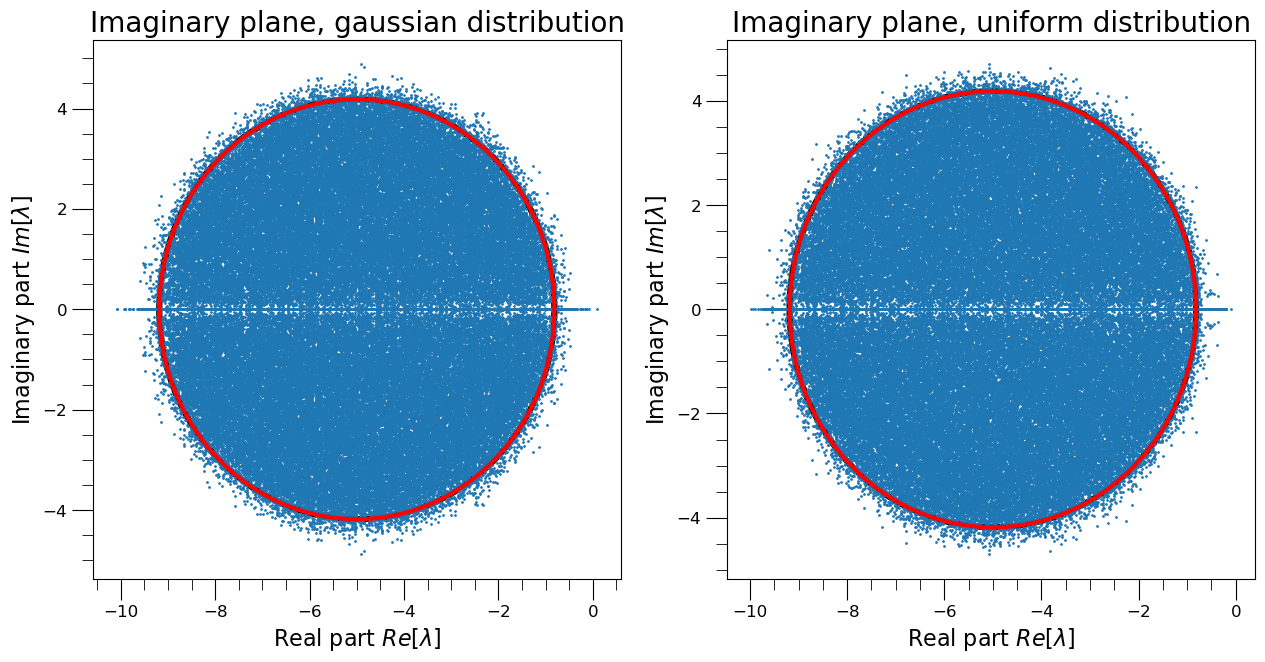

In [8]:
fig, ax_ = plt.subplots(1, 2, figsize=(15, 7))


distributions = {'gaussian': np.random.normal, 'uniform': np.random.uniform}

extrema = std * np.sqrt(3)
parameters = {'gaussian': {'loc': 0, 'scale': std}, 'uniform': {'low': -extrema, 'high': extrema}}

for i, ax in enumerate(ax_):
    ax.add_patch(plt.Circle((-d, 0), std * np.sqrt(S * C), color='red', fill=False, linewidth = 3, zorder = 2))
    ax.add_patch(plt.Circle((-d, 0), std * np.sqrt(S * C), color='black', fill=False, linewidth = 4.5, zorder = 1))
    ax.set_title(f'Imaginary plane, {list(distributions.keys())[i]} distribution', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=12, length=15)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
    ax.minorticks_on()
    ax.set_xlabel('Real part $Re[\\lambda]$', fontsize = 16)
    ax.set_ylabel('Imaginary part $Im[\\lambda]$', fontsize = 16)


    
    eigenvalues = np.concatenate([random_matrix(S, C, d, list(distributions.values())[i], list(parameters.values())[i]) for _ in range(realizations_number)])

        
    ax.scatter(eigenvalues.real, eigenvalues.imag, s = 1, color = 'C0')
        
    
    


plt.show()


## Observations
---
We can see that our the eigenvalue distribution more or less resembles the one predicted by ther circular law. The eigenvalues indeed are mostly
 uniformly distributed and inside the teorethical circle. <br>
We gotta remember though that the derivation of the law is based on the strong assumption of the existance of an equilibrium $N^*_s = (1, 1, ..., 1)$ that allows us to write $J_{ij} = \alpha_{ij}$ with $\alpha$ our adjacency matrix. <br>
Furthermore the result does not vary significantly, as expected, between the 2 distribution chosen. <br>



## 2) Mutualistic structure

In this second section of the notebook we study the case in which we introduce correlation between each species, we will use a Gaussian with mean $0$ as our distribution. <br>
What is found analytically is that in the complex plane we now have an ellipse with semi-axis dependent on the values of the correlation coefficient $\rho$. In particular the two semiaxis are, <br>

<br/>

$$

\begin{cases}

a \approx \sqrt{S \cdot V} \cdot (1 + \rho) \\
\\
b \approx \sqrt{S \cdot V} \cdot (1 - \rho) \\

\end{cases}
$$

Where $V$ is the variance of the distribution of the interaction strengths $\quad V = Var(\alpha_{ij}) \quad$ and $\rho$ is the correlation defined as $ \quad \rho =\dfrac{ \mathbb{E} \big[ \alpha_{i,j} \alpha_{j,i} \big] - \mathbb{E} ^2 
\big[ \alpha_{i,j} \big] }{Var(\alpha_{i,j})}$. <br>

<br/>

Before computing the variables of interest we begin by describing the procedure used to generate the random matrix $\alpha_{i,j}$. <br>
At each step we draw from a random distribution two independent numbers $x_1$ and $x_2$, to build the matrix with the correct structure we then apply a tranformation $x_1$ and $x_2$, for a predator-prey interaction we have $x_1 \rightarrow |x_1|$, $x_2 \rightarrow -|x_2|$, for a mutualistic interaction instead we have $x_1 \rightarrow |x_1|$, $x_2 \rightarrow |x_2|$. <br>

<br/>

In order to compute $\mathbb{E}[\alpha_{ij}]$ we notice that by construction, it is nothing different from $\mathbb{E}[|x|]$ or better, in our case, $C \cdot \mathbb{E}[|x|]$ which is,

$$

\mathbb{E}[|x|] = \int_{-\infty}^{\infty} |x| \cdot P(x) \cdot dx = \int_{-\infty}^{\infty} |x| \dfrac{1}{\sigma\sqrt{2 \pi}} e^{-\frac{x^2}{2 \sigma^2}} \cdot dx \quad =

$$

$$

\quad = \dfrac{2}{\sigma\sqrt{2 \pi}} \cdot \int_{0}^{\infty} xe^{-\frac{x^2}{2 \sigma^2}} \cdot \mathcal{d}x \quad \text{making the change of variable} \quad u = \frac{x^2}{2 \sigma^2} \quad \text{we get} \quad

$$

$$

\dfrac{2}{\sigma\sqrt{2 \pi}} \cdot \int_{0}^{\infty} e^{- \frac{u}{\sigma^2}} \mathcal{d}u = \dfrac{2 \sigma}{\sqrt{2 \pi}} 

$$



and with a similar reasoning we have $\mathbb{E} \big[ \alpha_{i,j} \alpha_{j,i} \big] = C \cdot \mathbb{E}^2 \big[ |x| \big]$.

<br/>

We start by computing the variance, $Var(\alpha_{ij}) = \mathbb{E[{a_{ij}a_{ij}}]} - \mathbb{E^2[a_{ij}]}$ which is given by,

<br/>


$$

Var(\alpha_{ij}) = \mathbb{E[x^2]} - \mathbb{E^2[\big|x\big|]} = C \cdot \sigma^2 - C^2 \cdot \dfrac{2 \sigma^2}{\pi} = C \sigma^2 \cdot (1 - C \cdot \dfrac{2}{\pi})

$$

<br/>

From all this follows that $ \quad \rho =\dfrac{ \mathbb{E} \big[ \alpha_{i,j} \alpha_{j,i} \big] - \mathbb{E} ^2 
\big[ \alpha_{i,j} \big] }{Var(\alpha_{i,j})} = \dfrac{C \mathbb{E}^2(x) - C^2 \mathbb{E^2(x)}}{Var(a_{ij})} = \dfrac{\cancel{C} \mathbb{E}^2(x) \cdot (1 - C)}{ \cancel{C} \sigma^2 \cdot (1 - C \dfrac{2}{\pi})},$

<br/>

$$

\rho = \dfrac{\cancel{4}^2 \cancel{\sigma^2} \cdot (1 - C)}{\cancel{2} \pi \cancel{\sigma^2} \cdot (1 - C\dfrac{2}{\pi})},

$$


$$

\rho = \dfrac{2 (1 - C)}{\pi \cdot (1 - C \dfrac{2}{\pi})} = \dfrac{1 - C}{\dfrac{\pi}{2} - C}

$$

<br/>




### Verifying the analytical results

Before carrying on ioth the notebook we choose to verify numerically the analytical results written above on a random matrix. <br>

In [43]:
n_species = 100
std = 0.5
d = 5
C = 0.7

random_matrix = np.random.normal(size = (n_species, n_species), loc = 0, scale = std)
random_matrix = np.abs(random_matrix)
np.fill_diagonal(random_matrix, -d)




off_diagonal_mask = np.eye(random_matrix.shape[0], dtype = bool)
off_diagonal_indexes = np.where(~ off_diagonal_mask)

off_diagonal_values = random_matrix[off_diagonal_indexes].flatten()
var_c1 = np.var(off_diagonal_values)
mean_c1 = np.mean(off_diagonal_values)

# Set the off-diagonal non zero entries to zero with a probability of 1-C
off_diagonal_values[(np.random.uniform(size = S*S - S)) > C] = 0

print(f'''
The theoretical mean of the off diagonal terms with C = 1 is {(2* 0.5)/(np.sqrt((2 * np.pi))):.3f}
The numerical mean of the off diagonal term is {mean_c1:.3f}
The theoretical mean of the off diagonal terms with C = 0.7 is {0.7 * (2* 0.5)/(np.sqrt((2 * np.pi))):.3f}
The numerical mean of the off diagonal terms with C = 0.7 is, {np.mean(off_diagonal_values):.3f}
0.7 times the numerical mean is, {C * mean_c1:.3f}
''')
print('-------------------------')




matrix = np.random.normal(size=(S, S), loc = 0, scale = 0.5)
matrix = np.abs(matrix)

original_upper = matrix[np.triu_indices(S, k = 1)].flatten()
original_lower = matrix[np.tril_indices(S, k = -1)].flatten()

mask_func = np.vectorize(lambda x: 0 if x > C else 1)

mutualistic_mask = np.triu(np.random.uniform(size = (S, S)), k = 1)

mutualistic_mask = mask_func(mutualistic_mask)

mutualistic_mask[np.tril_indices(S, k= -1)] = 0

final_mask = mutualistic_mask.T + mutualistic_mask 

# Set the off-diagonal non zero entries to zero with a probability of 1-C
matrix = matrix * final_mask

upper_diagonal_terms = matrix[np.triu_indices(S, k = 1)].flatten()
lower_diagonal_terms = matrix[np.tril_indices(S, k = -1)].flatten()

product_terms_C = np.multiply(upper_diagonal_terms, lower_diagonal_terms)
product_terms_no_C = np.multiply(original_upper, original_lower)





print(f'''
The theoretical mean of the product terms aij * aji with C = 1 is {(2* 0.5)/(np.sqrt((2 * np.pi)))**2:.3f}
The numerical mean of the product terms aij * aji with C = 1 is {np.mean(product_terms_no_C):.3f}
The theoretical mean of the product terms aij * aji with C = 0.7 is {C * ((2* 0.5)/(np.sqrt((2 * np.pi))))**2:.3f}
The numerical mean of the product terms aij * aji with C = 0.7 is, {C * 2 * np.mean(product_terms_C):.3f}
C times the numerical mean is, {C * np.mean(product_terms_no_C):.3f}
''')

print('-------------------------')


print(f'''
The theoretical variance of the off diagonal terms with C = 1 is {(std ** 2) * (1 - 2/np.pi):.3f}
The numerical variance of the off diagonal term is {var_c1:.3f}
The theoretical variance of the off diagonal terms with C = 0.7 is {C * (std ** 2) * (1 - (2 * C)/np.pi):.3f}
The numerical variance of the off diagonal terms with C = 0.7 is, {np.var(off_diagonal_values):.3f}
''')

print('-------------------------')


cov = np.cov(random_matrix)
upper_triangular_cov = cov[np.triu_indices(n_species, k = 1)].flatten()
upper_triangular_cov = upper_triangular_cov[np.where(upper_triangular_cov > 0)]

lower_triangular_cov = cov[np.tril_indices(n_species, k = -1)].flatten()
lower_triangular_cov = lower_triangular_cov[np.where(lower_triangular_cov > 0)]

mean_cov = np.mean(np.concatenate((upper_triangular_cov, lower_triangular_cov)))



print(f'''
We can also verify that the correlation is 0 printing the mean of the off-diagonal matric of the covariance matrix (we do it for the case of C = 1 without loss of generality), that is: {mean_cov:.3f}
''')


The theoretical mean of the off diagonal terms with C = 1 is 0.399
The numerical mean of the off diagonal term is 0.399
The theoretical mean of the off diagonal terms with C = 0.7 is 0.279
The numerical mean of the off diagonal terms with C = 0.7 is, 0.281
0.7 times the numerical mean is, 0.280

-------------------------

The theoretical mean of the product terms aij * aji with C = 1 is 0.159
The numerical mean of the product terms aij * aji with C = 1 is 0.154
The theoretical mean of the product terms aij * aji with C = 0.7 is 0.111
The numerical mean of the product terms aij * aji with C = 0.7 is, 0.108
C times the numerical mean is, 0.108

-------------------------

The theoretical variance of the off diagonal terms with C = 1 is 0.091
The numerical variance of the off diagonal term is 0.091
The theoretical variance of the off diagonal terms with C = 0.7 is 0.097
The numerical variance of the off diagonal terms with C = 0.7 is, 0.098

-------------------------

We can also verify t

Other than the fact that now we have an ellipse and not a circle, we notice also another thing that is different from the previous case. <br>
We can see infact how the mean of the distribution is not zero, but it is in fact $C \cdot \mathbb{E}[|x|]$ bringing to us the "outlier" eigenvalue at $(S - 1) \cdot C \mathbb{E}[|x|] - d \quad = \quad C \cdot (S - 1) \cdot 
\dfrac{2 \sigma}{\sqrt{2 \pi}} - d$, let's verify it graphically with an example.

<br/>

In [39]:
def mutualistic_random_matrix(S, C, d, distribution, parameters):

    # Generate a random a SxS matrix with non zero entries hsving a probability of C 
    # Set the diagonal to -d. 

    # S: number of species
    # C: percentage of non zero entries
    # d: diagonal value
    # distribution: numpy random distribution of the non zero entries
    # parameters: parameters of the numpy distribution (has to be a dictionary)

    # Generate a random matrix
    matrix = distribution(size=(S, S), **parameters)

    matrix = np.abs(matrix)

    
    # Set the diagonal to -d
    

    mutualistic_mask = np.triu(np.random.uniform(size = (S, S)), k = 1)

    mask_func = np.vectorize(lambda x: 0 if x > C else 1)

    mutualistic_mask = mask_func(mutualistic_mask)

    mutualistic_mask[np.tril_indices(S, k= -1)] = 0

    final_mask = mutualistic_mask.T + mutualistic_mask 

    # Set the off-diagonal non zero entries to zero with a probability of 1-C
    matrix = matrix * final_mask

    
    np.fill_diagonal(matrix, -d)

    # Calculate the eigenvalues
    eigenvalues = np.linalg.eigvals(matrix)
    
    

    return eigenvalues

In [40]:
eigenvalues = np.concatenate([mutualistic_random_matrix(S, C, d, distributions['gaussian'], parameters['gaussian']) for _ in range(realizations_number)])
    

In [41]:
print(f'''
We expect the system to be unstable as the theroetical real part of the "outlier" eigenvalue is {C * (S - 1) * ((2 * std) / (np.sqrt(2 * np.pi))) - d:.3f} 




''')


We expect the system to be unstable as the theroetical real part of the "outlier" eigenvalue is 22.647 







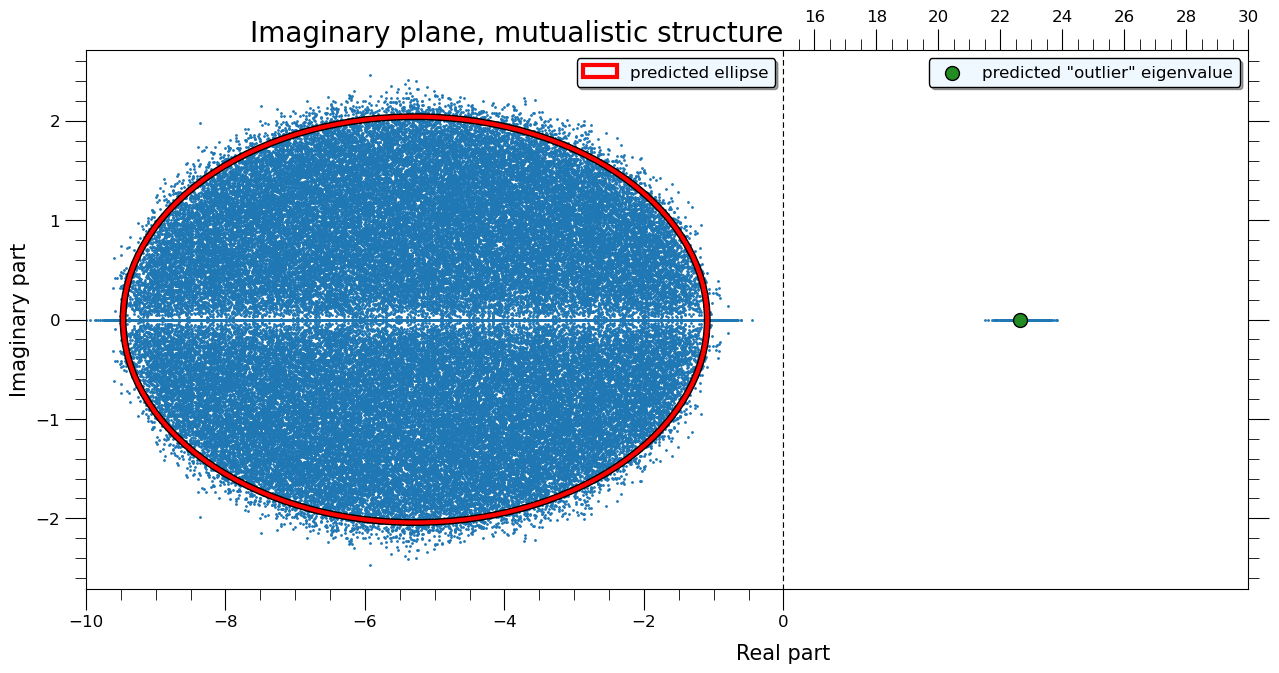

In [54]:
import matplotlib

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7), sharey=True, gridspec_kw={'wspace': 0, 'width_ratios': [3, 2]})
ax1.scatter(eigenvalues.real, eigenvalues.imag, s = 1, color = 'C0')
ax1.set_xlim(-10, 0)
ax2.scatter(eigenvalues.real, eigenvalues.imag, s = 1, color = 'C0')
ax2.set_xlim(15, 30)
ax2.spines['left'].set_linestyle((0, (4, 4)))
#ax1.add_patch(plt.Circle((-d - C * (2 * std/ np.sqrt(np.pi * 2)), 0), np.sqrt(C * std**2 * (1 - C * (2 / np.pi)) * S), color='red', fill=False, linewidth = 3, zorder = 2, label = 'predicted circle'))
#ax1.add_patch(plt.Circle((-d - C * (2 * std/ np.sqrt(np.pi * 2)), 0), np.sqrt(C * std**2 * (1 - C * (2 / np.pi)) * S), color='black', fill=False, linewidth = 5, zorder = 1))
ax2.scatter(C * (S - 1) * ((2 * std) / (np.sqrt(2 * np.pi))) - d, 0, edgecolor = 'black', color = 'forestgreen', s = 100, zorder = 3, label = 'predicted "outlier" eigenvalue')
ax2.xaxis.tick_top()


ax2.yaxis.tick_right()

for ax in [ax1, ax2]:
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=12, length=15)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=8)

ax1.set_xlabel('Real part', fontsize = 15)
ax1.set_ylabel('Imaginary part', fontsize = 15)
ax1.xaxis.set_label_coords(1, -.1)

ax1.set_title('Imaginary plane, mutualistic structure', fontsize = 20, loc = 'right')


rho = (1-C)/((np.pi/2) - C)


ax1.add_patch(matplotlib.patches.Ellipse(xy = (-d - C * (2 * std)/ np.sqrt(2 * np.pi), 0) ,
                                     width =2 *  np.sqrt(S*C*(std**2)*(1 - 2*C/np.pi))*(1 + rho),
                                     height = 2 * np.sqrt(S*C*(std**2)*(1 - 2*C/np.pi))*(1 - rho),\
                                        color='red', fill=False, linewidth = 3, zorder = 2, label = 'predicted ellipse'))                                        

ax1.add_patch(matplotlib.patches.Ellipse(xy = (-d - C * (2 * std)/ np.sqrt(2 * np.pi), 0) ,
                                     width =2 *  np.sqrt(S*C*(std**2)*(1 - 2*C/np.pi))*(1 + rho),
                                     height = 2 * np.sqrt(S*C*(std**2)*(1 - 2*C/np.pi))*(1 - rho),\
                                        color='black', fill=False, linewidth = 5, zorder = 1))   

ax1.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True, fontsize = 12)
ax2.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True, fontsize = 12)                                        

plt.show()


In [57]:
print(f'The value of rho is {rho:.2f}')

The value of rho is 0.34


We can see that the mutualistc interaction makes the system more unstable, that is because $\rho > 0, \quad \rho \approx 0.34 \quad$  and so the semi-axis $a$ is bigger than $b$.

## Observations

We can immediately notice how the eigenvalue caused by the matrix non having mean $0$ makes the system unstable as its Real part is greater then zero.<br>



## Scaling of the Maximum Eigenvalue

In this section we study how the maximum real part between between all the eigenvalues scales at various values of the number of species $S$ we choose as values $S = [20, ..., 100]$. <br>
We expect to find, in our setting, something linear as the the maximum eigenvalue is given by the condititon,

$$

max \big\{   \sqrt{(SV)} \cdot (1 \pm \rho) - C \mu -d, \quad  (S - 1) \cdot C \mu -d  \big\},

$$

In our case our condition can be formulated as,

$$

max \big\{   \sqrt{(SV)} \cdot (1 + \rho), \quad S \cdot C \mu   \big\}; \quad max \big\{\sqrt{(SC \sigma^2) \cdot( 1 - C \dfrac{2}{\pi})}\cdot (1 + \rho), \quad  S \cdot C \mu  \big\}; \quad max \big\{\sqrt{(SC \sigma^2) \cdot( 1 - C \dfrac{2}{\pi})}\cdot (1 + \rho), \quad  S \cdot C \dfrac{2 \sigma}{\sqrt{2 \pi}}  \big\},

$$

And looking at the extrema of our interval $(S = 20\text{ and }S = 100)$ we get respectively $\approx max\{  1.39, \quad 5.59  \}$ and $\approx \max\{   3.11, \quad 27.93   \}$ and so the linear part prevales, let's check it below.


The maximum condition for S = 100 is,
4.187763456753246, 27.92595962810029

The maximum condition for S = 20 is,
1.872824752597952, 5.585191925620058



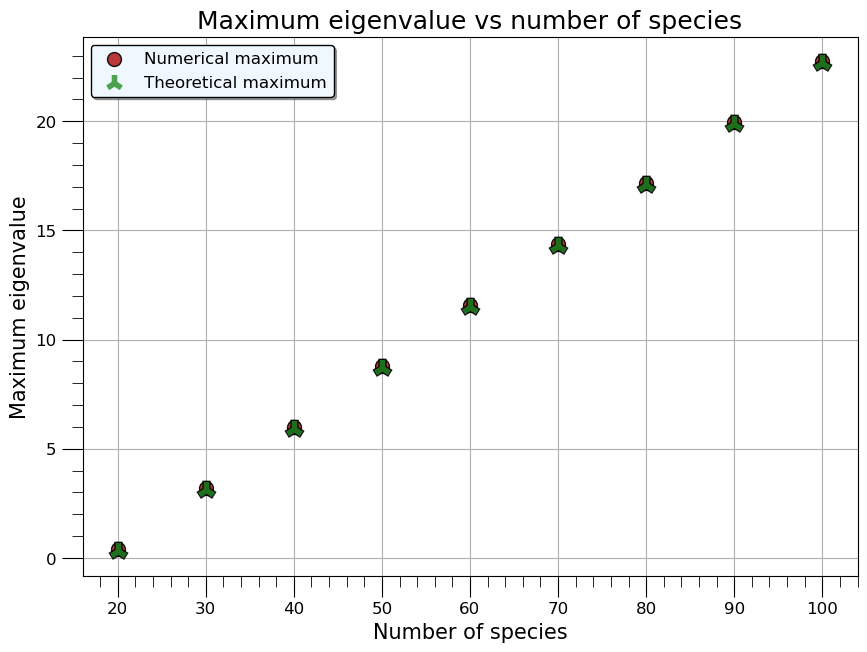

In [84]:
print(f'''
The maximum condition for S = 100 is,
{np.sqrt((S := 100 * C * std**2) * (1 - C * (2 / np.pi)) ) * (1 + rho)}, {(S := 100) * C * (2 * std) / (np.sqrt(2 * np.pi))}

The maximum condition for S = 20 is,
{np.sqrt((S := 20 * C * std**2) * (1 - C * (2 / np.pi)) ) * (1 + rho)}, {(S := 20) * C * (2 * std) / (np.sqrt(2 * np.pi))}
''')

V = C * std**2 * (1 - (2*C)/ np.pi)

mu = (2*std)/(np.sqrt(2*np.pi))


C = 0.7



range_species = np.arange(20, 101, 10)

max_eigenvalues = [np.mean([np.max(mutualistic_random_matrix(species, C, d, distributions['gaussian'], parameters['gaussian']).real)\
      for _ in range(1000)]) for species in range_species]

predicted_eig = [np.max( np.array([ (np.sqrt(species*V)*(1 + rho)- C*mu -d) , ((species-1)*C*mu -d) ] )) for species in range_species]

fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(range_species, max_eigenvalues, s= 100, color = 'firebrick', edgecolor = 'black', zorder = 2, alpha = 0.9, label = 'Numerical maximum')
ax.scatter(range_species, predicted_eig, s= 150, color = 'forestgreen', marker = '2', alpha = 0.8, linewidths=4, zorder = 4, label = 'Theoretical maximum')
ax.scatter(range_species, predicted_eig, s= 200, color = 'black', marker = '2', alpha = 0.9, linewidths=6, zorder = 3)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.set_ylabel('Maximum eigenvalue', fontsize = 15)
ax.set_xlabel('Number of species', fontsize = 15)
ax.set_title('Maximum eigenvalue vs number of species', fontsize = 18)
ax.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True, fontsize = 12)
ax.minorticks_on()
ax.grid(zorder = 1)
plt.show()

If we wanna see a square root dependance we have to satisfy the condition,

$$

\sqrt{(SC \sigma^2) \cdot( 1 - C \dfrac{2}{\pi})} \cdot (1 + \rho) - C \mu -d \geq (S - 1) \cdot C \mu -d,

$$

Where $\mu$ is our mean,

$$

\sqrt{(SC \sigma^2) \cdot( 1 - C \dfrac{2}{\pi})} \cdot(1 + \rho) \geq SC \mu,

$$

after squaring both sides we get,

$$

\cancel{S}\cancel{C} \sigma^2 \cdot (1 - C \dfrac{2}{\pi}) \cdot (1 + \rho)^2  \geq S^{\cancel{2}} C^{\cancel{2}} \mu^2,

$$

$$

\sigma^2 \geq \dfrac{S C \mu^2}{(1 - C\dfrac{2}{\pi}) \cdot (1 + \rho)^ 2},

$$

Substituting in our formula for $\mu$, $\mu$ = $\dfrac{2 \sigma}{\sqrt{2 \pi} }$ we get


$$

\cancel{\sigma^2} \geq \dfrac{4 S C \cancel{\sigma^2}}{(1 - C\dfrac{2}{\pi}) \cdot 2 \pi \cdot(1 + \rho)^2},

$$

$$

2 \pi (1 - C \dfrac{2}{\pi}) \cdot (1 + \rho)^2 \geq 4 S C,

$$

$$

(2 \pi - 4C) \cdot (1 + \rho^2 + \rho) \geq 4 S C,

$$

re-ordering,

$$

C \cdot (4S + 8 \rho + 4 \rho^2 + 4) \leq 2 \pi(1 + \rho)^2,

$$

and finally,

$$

C \leq \dfrac{\pi (1 + \rho)^2}{2 \cdot (S + (1 + \rho)^2)},

$$

That in our case, with $S = 100$ results in $C \lessapprox 0.028 $, let's see if in this case wee see a square root dependance as we would expect

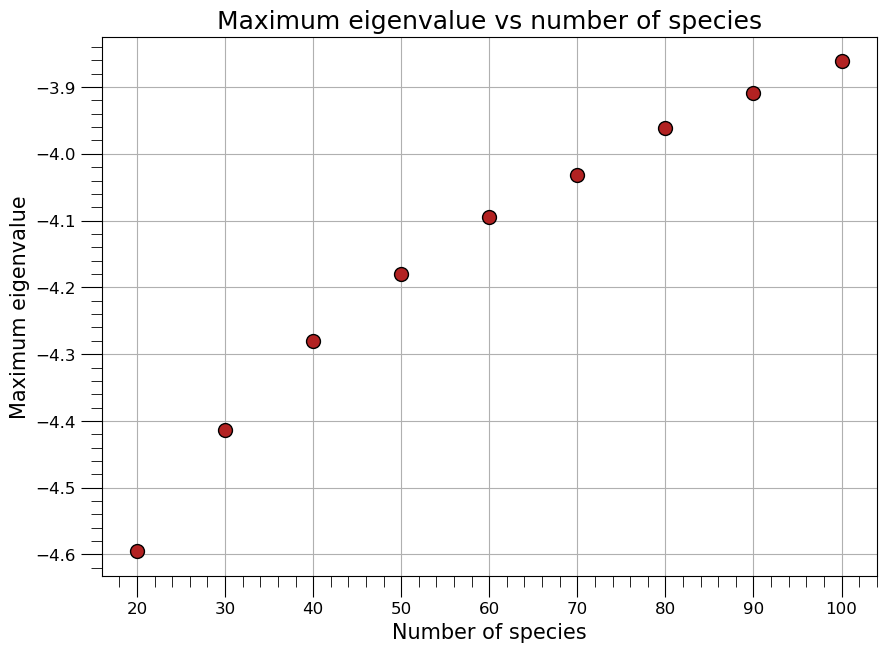

In [87]:
max_eigenvalues = [np.mean([np.max(mutualistic_random_matrix(species, C := 0.01, d, distributions['gaussian'], parameters['gaussian']).real)\
      for _ in range(1000)]) for species in range_species]




fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(range_species, max_eigenvalues, s= 100, color = 'firebrick', edgecolor = 'black', zorder = 2)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.set_ylabel('Maximum eigenvalue', fontsize = 15)
ax.set_xlabel('Number of species', fontsize = 15)
ax.set_title('Maximum eigenvalue vs number of species', fontsize = 18)
ax.minorticks_on()
ax.grid(zorder = 1)
plt.show()

Where we can see the square root dependance.

## 3) Analyzing the food web

In this section of the notebook we import the food web data and we analyze it computing some of the metrics of interest that include:

- Generality of a species: how many species it predates, defined as    $  G_i = \sum\limits_{j = 1}^{S} \dfrac{a_{ji}}{LS}  $ where L is the number of links in the network

- Vulnerability of a species: how many species it is preyed by, defined as $  V_i = \sum\limits_{j = 1}^{S} \dfrac{a_{ij}}{LS}  $

- Overlap (Connected to trophic similarity): the number of predators and preys shared by two species, defined as $ S_{ij} = \dfrac{\sum_{k} a_{ki}a_{kj}  + \sum_{k}a_{ik}a_{jk}}{S}$

- Trophic level, $S_i = 1 + \dfrac{1}{ k_i^{in} } \sum\limits_{j = 1}^{S}a_{ji}S_j$ where $K_i^{in}$ is the number of incoming links of node i. If a graph with adjacency matrix A has at least a basal node, and every species belongs to at least one food chain, then $S_i$ defines the trophic level of node i.

- Trophic difference: defined as $X_{ij} = S_i - S_j$

- Trophic coherence: how neatly nodes fall into distinct levels of the network, defines as $q = \sqrt{\langle X^2 \rangle - \langle X \rangle^2} \quad = \quad \sqrt{\sum\limits_{ij}a_{ij}X_{ij}^2 - \big( \sum\limits_{ij}a_{ij}X_{ij} \big)^2}  $.

We choose the property of $p(X)$ so that $\langle X \rangle = \sum_{ij} a_{ij} X_{ij} = 1$, in this case for the trophic coherence we are left to compute $\quad q = \sqrt{\langle X^2 \rangle - 1}$


In [2]:
food_web = pd.read_excel('../../data/Week_4/Food-web-Dataset-PNAS-05.xls', index_col = 0)
food_web

,D1,A1,A2,A3,I1,I2,I3,I4,I5,I6,...,F199,F200,F201,F202,F203,F204,F205,F206,F207,F208
prey\predator,,,,,,,,,,,,,,,,,,,,,
D1,0,0,0,0,0.000000,0.000226,0.000006,0.000001,0.000001,0.000002,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0,2.266301e-07,3.244932e-07,0.000000
A1,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0,4.724895e-06,1.682557e-06,0.000000
A2,0,0,0,0,0.000000,0.000000,0.000000,0.000022,0.000022,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0,1.016026e-06,0.000000e+00,0.000000
A3,0,0,0,0,0.026745,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0,0.000000e+00,0.000000e+00,0.000000
I1,0,0,0,0,0.000000,0.000000,0.000000,0.000685,0.000685,0.003196,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F204,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000413,0.0,0.000000,0.000000,0.0,0.0,0,0.000000e+00,0.000000e+00,0.000000
F205,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001256,0.0,0.000000,0.000278,0.0,0.0,0,0.000000e+00,0.000000e+00,0.000587
F206,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001797,0.0,0.000000,0.000000,0.0,0.0,0,0.000000e+00,0.000000e+00,0.000000


In [3]:
# Binarizing the food web

food_web = food_web.applymap(lambda x: 1 if x > 0 else 0, na_action='ignore')
food_web

,D1,A1,A2,A3,I1,I2,I3,I4,I5,I6,...,F199,F200,F201,F202,F203,F204,F205,F206,F207,F208
prey\predator,,,,,,,,,,,,,,,,,,,,,
D1,0,0,0,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,1,1,0
A1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
A2,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
A3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I1,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F204,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
F205,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
F206,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [4]:
# Finding the total number of species

S = food_web.shape[0]
print(f'''
The food web has {S} species.
''')


The food web has 249 species.



In [5]:
# Computing the generality of the food web
sum_axis = {'rows': 0, 'columns': 1}

food_web_matrix = np.array(food_web)

L = np.sum(food_web_matrix) # number of links

generality_array = np.sum(food_web_matrix, axis = sum_axis['rows']) / (L * S)


pd.DataFrame(generality_array, columns = ['Generality'], index = food_web.index)

,Generality
prey\predator,
D1,0.000000
A1,0.000000
A2,0.000000
A3,0.000000
I1,0.000002
...,...
F204,0.000032
F205,0.000000
F206,0.000021


In [6]:
# Computing the Vulnerability of the food web

vulnerability_array = np.sum(food_web_matrix, axis = sum_axis['columns']) / (L * S)

pd.DataFrame(vulnerability_array, columns = ['Vulnerability'], index = food_web.index)

,Vulnerability
prey\predator,
D1,0.000059
A1,0.000085
A2,0.000036
A3,0.000015
I1,0.000028
...,...
F204,0.000008
F205,0.000016
F206,0.000005


In [7]:
# Computing the Overlap of the food web

trophic_similarity = (food_web_matrix.T.dot(food_web_matrix) + food_web_matrix.dot(food_web_matrix.T)) / S


### Overlap of the food web

In [8]:
pd.DataFrame(trophic_similarity, columns = food_web.columns, index = food_web.index)

,D1,A1,A2,A3,I1,I2,I3,I4,I5,I6,...,F199,F200,F201,F202,F203,F204,F205,F206,F207,F208
prey\predator,,,,,,,,,,,,,,,,,,,,,
D1,0.196787,0.116466,0.052209,0.040161,0.052209,0.132530,0.032129,0.036145,0.016064,0.024096,...,0.004016,0.004016,0.004016,0.008032,0.008032,0.004016,0.008032,0.000000,0.004016,0.008032
A1,0.116466,0.281124,0.096386,0.008032,0.032129,0.136546,0.108434,0.064257,0.052209,0.060241,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004016,0.000000
A2,0.052209,0.096386,0.120482,0.000000,0.024096,0.068273,0.060241,0.052209,0.044177,0.040161,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A3,0.040161,0.008032,0.000000,0.048193,0.028112,0.048193,0.008032,0.004016,0.004016,0.004016,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
I1,0.052209,0.032129,0.024096,0.028112,0.100402,0.068273,0.016064,0.016064,0.012048,0.012048,...,0.004016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004016,0.004016,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F204,0.004016,0.000000,0.000000,0.000000,0.000000,0.004016,0.000000,0.000000,0.000000,0.000000,...,0.096386,0.024096,0.064257,0.060241,0.024096,0.132530,0.024096,0.012048,0.008032,0.060241
F205,0.008032,0.000000,0.000000,0.000000,0.000000,0.004016,0.000000,0.000000,0.000000,0.000000,...,0.012048,0.016064,0.004016,0.012048,0.044177,0.024096,0.052209,0.016064,0.032129,0.012048
F206,0.000000,0.000000,0.000000,0.000000,0.004016,0.008032,0.004016,0.012048,0.012048,0.008032,...,0.008032,0.008032,0.004016,0.016064,0.008032,0.012048,0.016064,0.084337,0.060241,0.016064


In [9]:
# Computing the number of incoming lnks for each species

incoming_links = np.sum(food_web_matrix, axis = sum_axis['rows']) # The incoming links correspond to the species it predates



incoming_links_df = pd.DataFrame(incoming_links, columns = ['Incoming links'], index = food_web.index)
incoming_links_df.index = incoming_links_df.apply(lambda x: x.name.strip(), axis = 1) # Removing the spaces in the index
incoming_links_df

,Incoming links
D1,0
A1,0
A2,0
A3,0
I1,2
...,...
F204,26
F205,0
F206,17
F207,16


In [10]:
basal_species = incoming_links_df[incoming_links == 0]
basal_species.index.name = 'Basal_species'
basal_species.loc[:,'S_i'] = np.ones(basal_species.shape[0]).astype(int) # In the definition of S_i, S_i = 0 by definition if K_in = 0
basal_species

/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1411/4032121458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basal_species.loc[:,'S_i'] = np.ones(basal_species.shape[0]).astype(int) # In the definition of S_i, S_i = 0 by definition if K_in = 0


,Incoming links,S_i
Basal_species,,
D1,0,1
A1,0,1
A2,0,1
A3,0,1
F205,0,1


In [11]:
print(f'We have that the basal species of the food web, the ones that do not prey on any other species, are: {list(basal_species.index)}')

We have that the basal species of the food web, the ones that do not prey on any other species, are: ['D1', 'A1', 'A2', 'A3', 'F205']


In [12]:
incoming_links_df_sorted = incoming_links_df.sort_values(by = 'Incoming links', ascending = True) # Sorting the incoming links in ascending order
incoming_links_df['S_i'] = incoming_links_df.apply(lambda x: 1 if x['Incoming links'] == 0 else np.nan, axis = 1)

In [110]:
food_web.index = food_web.index.str.strip() # Removing the spaces in the index
food_web.columns = food_web.columns.str.strip() # Removing the spaces in the columns

In [109]:


def S_i(row, df_input, df_output):
    
    
    if int(np.nan_to_num(df_output.loc[row.name, 'S_i'] * 1, nan=0)) == 1:
        df_output.loc[row.name ,'S_i_final'] = df_output.loc[row.name, 'S_i']
    else:
        df_output.loc[row.name ,'S_i_final'] = (1/(df_input.loc[row.name, 'Incoming links'])) * np.sum(np.nan_to_num(food_web.loc[:,row.name] * \
            df_output['S_i_final'].to_numpy(), nan = 0) ) + 1

        


_ = incoming_links_df_sorted.apply(lambda x: S_i(x, incoming_links_df_sorted, incoming_links_df), axis = 1)



In [15]:
incoming_links_df_sorted['S_i_final'] = incoming_links_df_sorted.index.map(incoming_links_df.S_i_final)

### Printing the dataframe with the final values for $S_i$

In [16]:
incoming_links_df_sorted

,Incoming links,S_i_final
D1,0,1.000000
A1,0,1.000000
A2,0,1.000000
A3,0,1.000000
F205,0,1.000000
...,...,...
F208,110,3.089534
F66,112,3.083669
F34,155,3.295564
F39,170,3.298510


In [17]:
trophic_difference = np.array(incoming_links_df.S_i_final)[:,np.newaxis] - np.array(incoming_links_df.S_i_final)

In [18]:
trophic_coherence = np.sqrt(np.sum(food_web_matrix * trophic_difference**2) - 1)

In [19]:
print(f'''
The trophic coherence of the food web is {trophic_coherence:.3f}
''')


The trophic coherence of the food web is 59.965



<center>

| **Trophic coherence** | 59.965 |
|-----------------------|--------|

</center>

## Visualizing the Trophic levels

In the following cell we plot the number of incoming links (normalized by dividing by its standard deviation) and the trophic level to see if we notice a behaviour with the trophic level increasing with the number of incoming links (and therefore with the number of species preyed).

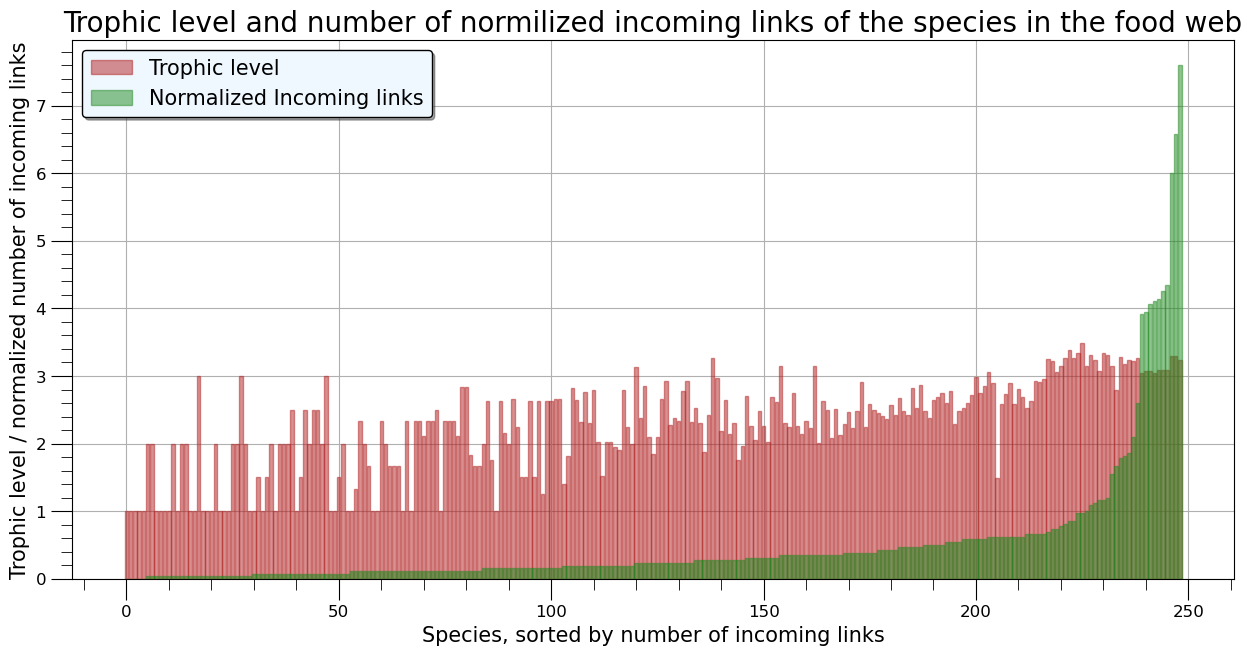

In [20]:
fig, ax = plt.subplots(figsize = (15, 7))
width = 0.8
ax.bar(np.arange(len(incoming_links_df_sorted)), incoming_links_df_sorted['S_i_final'], color = 'firebrick', width = width, alpha = 0.5, edgecolor = 'firebrick', zorder = 2,\
     label = 'Trophic level')
ax.bar(np.arange(len(incoming_links_df_sorted)), incoming_links_df_sorted['Incoming links'].to_numpy()/np.std(incoming_links_df_sorted['Incoming links'].to_numpy()),\
     color = 'forestgreen', alpha = 0.5, edgecolor = 'forestgreen', zorder = 2, label = 'Normalized Incoming links')

ax.set_xlabel('Species, sorted by number of incoming links', fontsize = 15)
ax.set_ylabel('Trophic level / normalized number of incoming links', fontsize = 15)
ax.grid(zorder = 1)
ax.minorticks_on()
ax.legend(fontsize = 15, facecolor = 'aliceblue', edgecolor = 'black', shadow = True)
ax.set_title('Trophic level and number of normilized incoming links of the species in the food web', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
plt.show()

## The cascade model

In this section we repeat a similar procedure to what we have done in point 1 but building the matrix in a different way. <br>
We consider an ecosystem of S species, connected within each oter (and even with self interactions) with $L$ links and a connectance $C$ suxh tthat $C \cdot S^2 = L$. <br>
We generate $S$ numbers from a uniform distribution defined between $0 \text{ and } 1$ that are called *Niche values* and represent the trophic level. <br>
Then if, calling the values extracted as $\mu_i$, if $\mu_i \geq \mu_j$ then $a_{ij} = 1$ and $a_{ji} = 0$ otherwise, that is, we put a link between the 2 species. The probability is chosen in order to obtain on average exatcly $L$ links. 

<br/>

In a generalized version a particular symmetry is introduced: the link between $i \text{ and } j$ occurs with probability $P(x) \approx \beta (1 -x)^{\beta - 1}$, where $x = max{0, \mu_i - \mu_j}$ where we can get $\beta $ form $C = \dfrac{1}{2(\beta + 1)}$


The matrix we build below is binarized and for practical reasons we name the species the same as the ones present in the previous food web.

In [107]:
S, C = 249, 0.3 # Re-defining S and C
trophic_levels = np.random.uniform(0, 1, size = S)

trophic_difference = trophic_levels[:,np.newaxis] - trophic_levels # Creating the matrix of mu_i - mu_j

mask_func = np.vectorize(lambda x: 1 if x > 0 else 0)
mask = mask_func(trophic_difference) # creating a matrix with ones if mu_i - mu_j > 0 and zeros otherwise

link_func = np.vectorize(lambda x: 1 if (np.random.uniform(size = 1) <  (2 * C * S)/(S - 1)) else 0) # Putting in the links with probability (2 * C * S)/(S - 1)

link_matrix = link_func(trophic_difference)

final_interaction_matrix = mask * link_matrix# Making survive onbly the links with mu_i > mu_j


print(f'''
Let's verify that parroximately the total number of links is C * S^2 = {C * S**2:.0f}.
In the built interaction matrix we have {(L := np.count_nonzero(final_interaction_matrix))} links.
''')


Let's verify that parroximately the total number of links is C * S^2 = 18600.
In the built interaction matrix we have 18620 links.



Let's now proceed to plot the imaginary plane of the eigenvalues.

In [105]:
cascade_df = pd.DataFrame(final_interaction_matrix)
cascade_df.columns = food_web.columns
cascade_df.index = food_web.index
cascade_df

,D1,A1,A2,A3,I1,I2,I3,I4,I5,I6,...,F199,F200,F201,F202,F203,F204,F205,F206,F207,F208
prey\predator,,,,,,,,,,,,,,,,,,,,,
D1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
A2,1,1,0,0,0,0,0,1,1,0,...,0,0,0,0,1,1,0,1,0,1
A3,1,1,0,0,0,1,1,0,0,0,...,1,0,0,0,1,0,1,0,1,1
I1,1,0,1,0,0,0,0,0,1,0,...,1,1,0,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F204,1,1,0,0,0,0,1,1,0,0,...,0,0,1,0,1,0,0,1,1,1
F205,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
F206,1,1,0,1,0,1,1,1,0,0,...,0,0,1,0,1,0,1,0,1,1


In [146]:
# Defining a function to compute all the important metrics of a given maritrix


def compute_metrics(matrix, df, L, S):
    
    generality_array = np.sum(matrix, axis = sum_axis['rows']) / (L * S)

    vulnerability_array = np.sum(matrix, axis = sum_axis['columns']) / (L * S)

    trophic_similarity = (matrix.T.dot(matrix) + matrix.dot(matrix.T)) / S

    incoming_links = np.sum(matrix, axis = sum_axis['rows']) # The incoming links correspond to the species it predates

    incoming_links_df = pd.DataFrame(incoming_links, columns = ['Incoming links'], index = df.index)

    incoming_links_df.index = incoming_links_df.apply(lambda x: x.name.strip(), axis = 1) # Removing the spaces in the index

    basal_species = incoming_links_df[incoming_links == 0]

    if len(basal_species) > 0:
        print('We are fine, we have at least one basal species')
    
        basal_species.index.name = 'Basal_species'
        basal_species.loc[:,'S_i'] = np.ones(basal_species.shape[0]).astype(int) # In the definition of S_i, S_i = 0 by definition if K_in = 0
        
        incoming_links_df_sorted = incoming_links_df.sort_values(by = 'Incoming links', ascending = True) # Sorting the incoming links in ascending order
        incoming_links_df['S_i'] = incoming_links_df.apply(lambda x: 1 if x['Incoming links'] == 0 else np.nan, axis = 1)


        _ = incoming_links_df_sorted.apply(lambda x: S_i(x, incoming_links_df_sorted, incoming_links_df), axis = 1)

        incoming_links_df_sorted['S_i_final'] = incoming_links_df_sorted.index.map(incoming_links_df.S_i_final)

        trophic_difference = np.array(incoming_links_df.S_i_final)[:,np.newaxis] - np.array(incoming_links_df.S_i_final)

        trophic_coherence = np.sqrt(np.sum(matrix * trophic_difference**2) - 1)


        return generality_array, vulnerability_array, trophic_similarity, basal_species, incoming_links_df, incoming_links_df_sorted, trophic_difference, trophic_coherence

    else:
        print('We have a problem, we do not have any basal species')
        return generality_array, vulnerability_array, incoming_links_df, basal_species

In [147]:
generality_array_cas, vulnerability_array_cas, trophic_similarity_cas, basal_species_cas, incoming_links_df_cas, incoming_links_df_sorted_cas, trophic_difference_cas,\
     trophic_coherence_cas = compute_metrics(final_interaction_matrix, cascade_df, L, S)

We are fine, we have at least one basal species


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1411/3431759394.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basal_species.loc[:,'S_i'] = np.ones(basal_species.shape[0]).astype(int) # In the definition of S_i, S_i = 0 by definition if K_in = 0


In [148]:
display(pd.DataFrame(generality_array, columns = ['Generality'], index = cascade_df.index))
display(pd.DataFrame(vulnerability_array, columns = ['Vulnerability'], index = cascade_df.index))


,Generality
prey\predator,
D1,0.000027
A1,0.000014
A2,0.000013
A3,0.000020
I1,0.000007
...,...
F204,0.000027
F205,0.000025
F206,0.000017


,Vulnerability
prey\predator,
D1,0.000005
A1,0.000020
A2,0.000019
A3,0.000013
I1,0.000024
...,...
F204,0.000003
F205,0.000009
F206,0.000017


In [149]:
display(pd.DataFrame(trophic_similarity_cas, columns=cascade_df.columns, index=cascade_df.index))

,D1,A1,A2,A3,I1,I2,I3,I4,I5,I6,...,F199,F200,F201,F202,F203,F204,F205,F206,F207,F208
prey\predator,,,,,,,,,,,,,,,,,,,,,
D1,0.590361,0.208835,0.200803,0.277108,0.132530,0.333333,0.068273,0.329317,0.228916,0.124498,...,0.136546,0.309237,0.236948,0.333333,0.064257,0.305221,0.329317,0.232932,0.329317,0.120482
A1,0.208835,0.630522,0.377510,0.309237,0.281124,0.248996,0.220884,0.216867,0.313253,0.313253,...,0.345382,0.152610,0.393574,0.220884,0.220884,0.164659,0.281124,0.365462,0.220884,0.305221
A2,0.200803,0.377510,0.598394,0.321285,0.257028,0.236948,0.232932,0.248996,0.325301,0.305221,...,0.317269,0.156627,0.393574,0.232932,0.212851,0.160643,0.277108,0.341365,0.208835,0.305221
A3,0.277108,0.309237,0.321285,0.618474,0.200803,0.317269,0.176707,0.321285,0.309237,0.240964,...,0.232932,0.220884,0.301205,0.301205,0.156627,0.244980,0.361446,0.329317,0.305221,0.236948
I1,0.132530,0.281124,0.257028,0.200803,0.578313,0.164659,0.277108,0.152610,0.200803,0.337349,...,0.321285,0.076305,0.289157,0.152610,0.253012,0.072289,0.164659,0.261044,0.148594,0.393574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F204,0.305221,0.164659,0.160643,0.244980,0.072289,0.265060,0.044177,0.261044,0.200803,0.100402,...,0.116466,0.297189,0.168675,0.257028,0.028112,0.562249,0.305221,0.208835,0.289157,0.080321
F205,0.329317,0.281124,0.277108,0.361446,0.164659,0.389558,0.112450,0.357430,0.317269,0.184739,...,0.208835,0.301205,0.253012,0.361446,0.112450,0.305221,0.642570,0.317269,0.373494,0.192771
F206,0.232932,0.365462,0.341365,0.329317,0.261044,0.293173,0.188755,0.285141,0.345382,0.309237,...,0.313253,0.168675,0.361446,0.297189,0.184739,0.208835,0.317269,0.638554,0.277108,0.273092


In [150]:
basal_species_cas

,Incoming links,S_i
Basal_species,,
F121,0,1


In [151]:
incoming_links_df_sorted_cas

,Incoming links,S_i_final
F121,0,1.000000
F12,1,1.000000
F82,1,1.000000
F140,1,1.000000
I22,2,1.000000
...,...,...
F165,148,1.020270
F33,148,1.717100
F112,150,1.064189
F47,151,1.028701


In [152]:
display(pd.DataFrame(trophic_difference_cas, columns=cascade_df.columns, index=cascade_df.index))

,D1,A1,A2,A3,I1,I2,I3,I4,I5,I6,...,F199,F200,F201,F202,F203,F204,F205,F206,F207,F208
prey\predator,,,,,,,,,,,,,,,,,,,,,
D1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018349,-0.026316,-0.031250,...,-0.181624,-0.013707,-0.271245,-0.737880,0.000000,-0.174844,0.000000,-0.105322,-0.112629,-0.871738
A1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018349,-0.026316,-0.031250,...,-0.181624,-0.013707,-0.271245,-0.737880,0.000000,-0.174844,0.000000,-0.105322,-0.112629,-0.871738
A2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018349,-0.026316,-0.031250,...,-0.181624,-0.013707,-0.271245,-0.737880,0.000000,-0.174844,0.000000,-0.105322,-0.112629,-0.871738
A3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018349,-0.026316,-0.031250,...,-0.181624,-0.013707,-0.271245,-0.737880,0.000000,-0.174844,0.000000,-0.105322,-0.112629,-0.871738
I1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018349,-0.026316,-0.031250,...,-0.181624,-0.013707,-0.271245,-0.737880,0.000000,-0.174844,0.000000,-0.105322,-0.112629,-0.871738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F204,0.174844,0.174844,0.174844,0.174844,0.174844,0.174844,0.174844,0.156495,0.148528,0.143594,...,-0.006780,0.161136,-0.096401,-0.563036,0.174844,0.000000,0.174844,0.069522,0.062215,-0.696894
F205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018349,-0.026316,-0.031250,...,-0.181624,-0.013707,-0.271245,-0.737880,0.000000,-0.174844,0.000000,-0.105322,-0.112629,-0.871738
F206,0.105322,0.105322,0.105322,0.105322,0.105322,0.105322,0.105322,0.086973,0.079006,0.074072,...,-0.076302,0.091614,-0.165923,-0.632558,0.105322,-0.069522,0.105322,0.000000,-0.007307,-0.766416


In [154]:
print(f'''

The trophic coherence of the cascade food web is {trophic_coherence_cas:.2f}.

''')



The trophic coherence of the cascade food web is 37.07.


